# UBER SUPPLY DEMAND GAP


In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("Uber Request Data.csv") # Reading Data

In [3]:
df.head() # First five rows of dataframe.

Request id Pickup point  Driver id          Status    Request timestamp  \
0         619      Airport        1.0  Trip Completed      11/7/2016 11:51   
1         867      Airport        1.0  Trip Completed      11/7/2016 17:57   
2        1807         City        1.0  Trip Completed       12/7/2016 9:17   
3        2532      Airport        1.0  Trip Completed      12/7/2016 21:08   
4        3112         City        1.0  Trip Completed  13-07-2016 08:33:16   

        Drop timestamp  
0      11/7/2016 13:00  
1      11/7/2016 18:47  
2       12/7/2016 9:58  
3      12/7/2016 22:03  
4  13-07-2016 09:25:47

In [4]:
df.info() #information regarding data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Request id         6745 non-null   int64  
 1   Pickup point       6745 non-null   object 
 2   Driver id          4095 non-null   float64
 3   Status             6745 non-null   object 
 4   Request timestamp  6745 non-null   object 
 5   Drop timestamp     2831 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 316.3+ KB


In [5]:
df.isnull().sum() # Counting all null values

Request id              0
Pickup point            0
Driver id            2650
Status                  0
Request timestamp       0
Drop timestamp       3914
dtype: int64

In [6]:
df[(df['Drop timestamp'].isnull())].groupby('Status').size() # Counting all null values grouping by Statuses

Status
Cancelled            1264
No Cars Available    2650
dtype: int64

Note: We can infer from above that Drop timestamp is empty when the Status is No Cars Available or Cancelled. Since the trips did not happen in those cases, the Drop timestamp have null values, hence the null values here are valid.

### Converting "Request timestamp" and "Drop timestamp" objects to date time to derive time slots.

In [7]:
# convert 'Drop timestamp' column to datetime oject
df["Drop timestamp"] = df["Drop timestamp"].astype(str)
df['Drop timestamp'] = df['Drop timestamp'].str.replace("/", "-")
df["Request timestamp"] = df["Request timestamp"].astype(str)
df['Request timestamp'] = df['Request timestamp'].str.replace("/", "-")
df["Request timestamp"] = pd.to_datetime(df["Request timestamp"])
df["Drop timestamp"] = pd.to_datetime(df["Drop timestamp"])

In [8]:
df['Req hour']=df["Request timestamp"].dt.hour
# Extracting hours from Request TImestamp

### Binning Into Time Periods

In [9]:
def time_period(x):
    "We will be diving the time into 5 slots"
    if x < 5:
        return "Early Morning" # creating slot of early morning for rides before 5AM
    elif 5 <= x < 12:
        return "Morning" # creating time slot of morning for rides after 5AM and before noon.
    elif 12 <= x < 17:
        return "Afternoon" # creating time slot of afternoon for rides after noon till 5pm.
    elif 17 <= x < 22:
        return "Evening" # creating time slot of morning for rides after 5pm till 10pm.
    else:
        return "Late Night" # anytime after 10pm will be considered late night.

In [10]:
df['Time slot'] = df['Req hour'].apply(lambda x: time_period(x))
# Creating New Column 'Time Slot'

## Visual Analysis

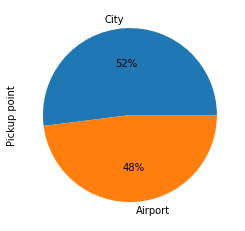

In [11]:
df["Pickup point"].value_counts().plot.pie(autopct='%1.0f%%')
plt.show()

There is slightly higher demand in City than Airport.

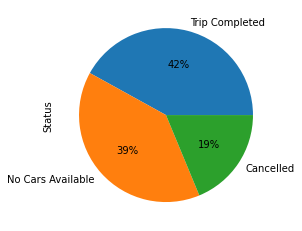

In [12]:
df["Status"].value_counts().plot.pie(autopct='%1.0f%%')
plt.show()

Since "Trip completed" is the supply fulfilled from Uber we can see that Uber is only able to meet 42% of its total demand whereas a big chunk of 39% is lost to No cars available and 19% to ride cancellations totalling 58% in lost revenues from no service provided.

In [13]:
df_city = df[df['Pickup point']=="City"] #City Data Only
df_airport = df[df['Pickup point']=="Airport"] #Airport Data Only

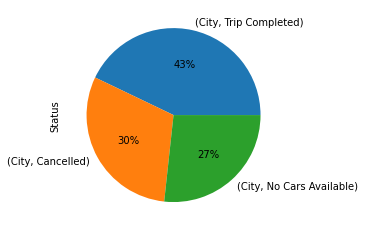

In [14]:
df_city.groupby(["Pickup point"]).Status.value_counts().plot.pie(autopct='%1.0f%%') #Comparison of City and its Statuses
plt.show()

57% of demand from the City is not being met. A good 30% of trips are cancelled by the drivers in city and a similar amount is lost due to No cars available.

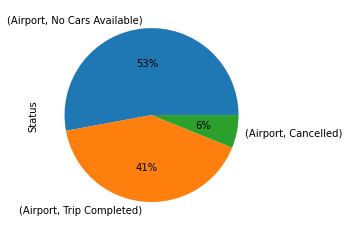

In [15]:
df_airport.groupby(["Pickup point"]).Status.value_counts().plot.pie(autopct='%1.0f%%') #Comparison of Airport and its Statuses
plt.show()

More than half of the time there is no cars available from Airport to City.

#### Plot data to show hourly distribution of request/demand

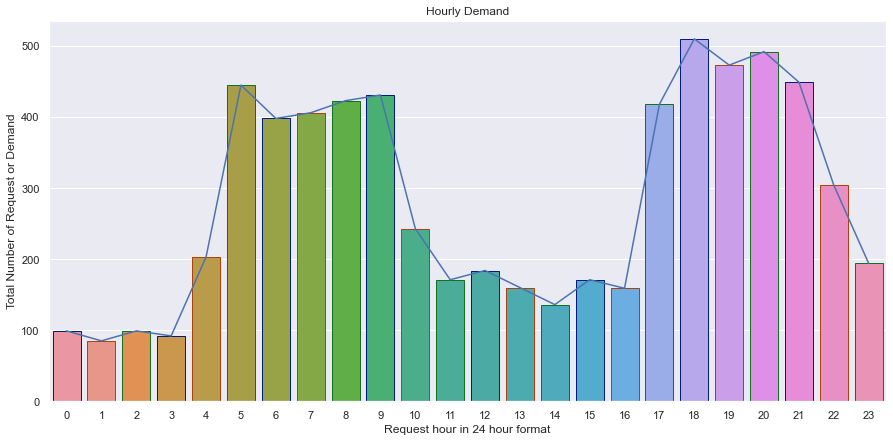

In [16]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(15,7))
plt.title('Hourly Demand')
df.groupby(df['Req hour']).count()['Request id'].plot(ax=ax)
sns.countplot(df['Req hour'], edgecolor=sns.color_palette("dark", 3))
plt.xlabel('Request hour in 24 hour format')
plt.ylabel('Total Number of Request or Demand')
plt.show()

We can infer from this above graph that at the 18 hour which is 6pm sees the highest demand for an Uber ride. While at 1am see the least request for an Uber ride.


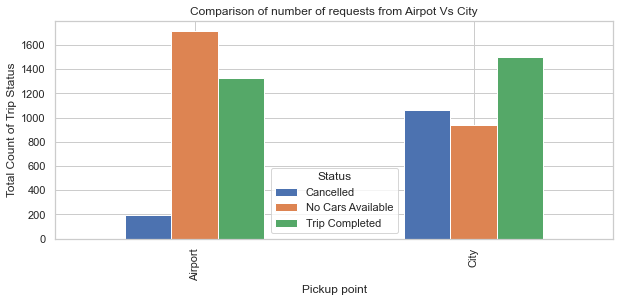

In [17]:
sns.set_style("whitegrid")
df.groupby(['Pickup point','Status']).Status.count().unstack().plot.bar(legend=True, figsize=(10,4))
plt.title('Comparison of number of requests from Airpot Vs City')
plt.xlabel('Pickup point')
plt.ylabel('Total Count of Trip Status')
plt.show()

We have seen the two pickup points analysis individually in the pie charts above. This is a side by side comparison of the two pickup points.

# Time Slot Analysis

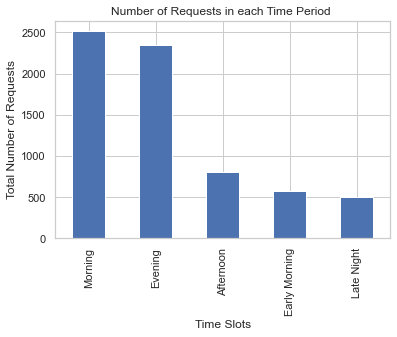

In [18]:
df['Time slot'].value_counts().plot.bar() # Number of Requests breakdown as per Time slots.
plt.title('Number of Requests in each Time Period ')
plt.xlabel('Time Slots')
plt.ylabel('Total Number of Requests')
plt.show()

We can infer from above graph that Mornings and Evenings are 'Rush hour' periods for an Uber request.

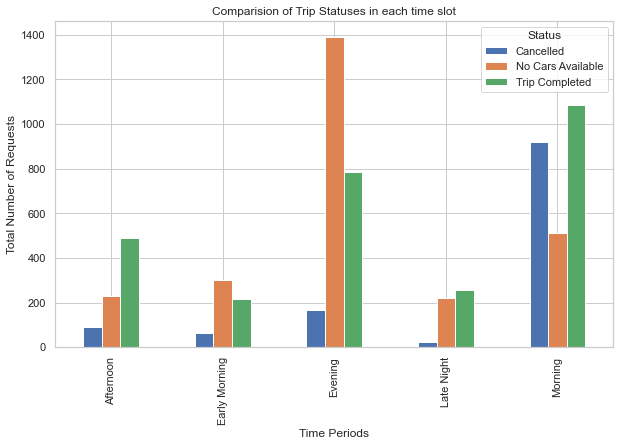

In [19]:
df.groupby(['Time slot','Status']).Status.count().unstack().plot.bar(legend=True, figsize=(10,6))
plt.title('Comparision of Trip Statuses in each time slot')
plt.xlabel('Time Periods')
plt.ylabel('Total Number of Requests')
plt.show()

Majority of the supply gap during Evenings is due to No Cars Available for trips. While majority of the trips are cancelled in the Morning.


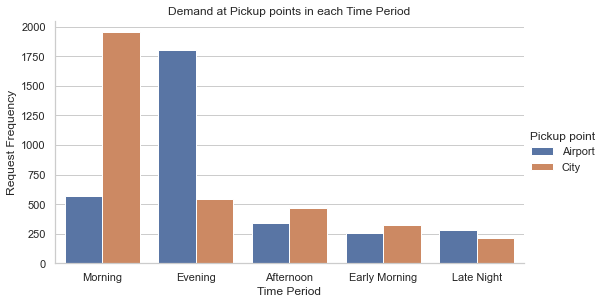

In [20]:
sns.factorplot(x='Time slot', hue='Pickup point' , data=df , kind='count', height=4, aspect=11/6)
plt.title('Demand at Pickup points in each Time Period')
plt.xlabel('Time Period')
plt.ylabel('Request Frequency')
plt.show()
plt.close()

We can clearly see there is a rush hour during Mornings at City and rush hour during Evenings at Airport. 
We will analyze it further below

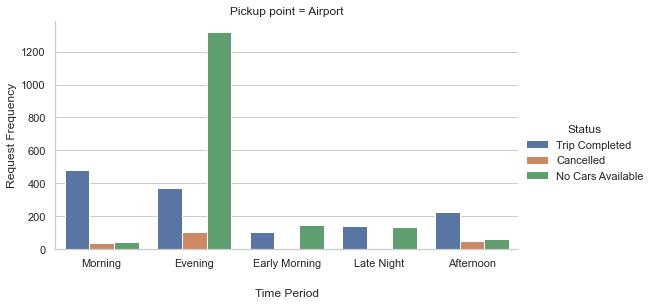

In [21]:
# let's look at the supply and demand gap in evening rush hour at Airport
sns.catplot(x= 'Time slot', hue='Status',row ='Pickup point', data= df_airport , kind='count',height=4, aspect=11/6)
plt.ylabel('Request Frequency')
plt.xlabel('Time Period',labelpad=20)
plt.show()

There is a huge supply gap during Evenings at Airport mainly due to No Cars Available.

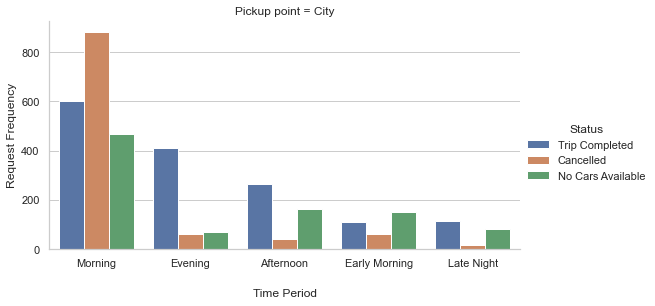

In [22]:
# let's look at the supply and demand gap in morning rush hour in City
sns.catplot(x='Time slot', hue='Status',row ='Pickup point', data=df_city , kind='count', height=4, aspect=11/6)
plt.ylabel('Request Frequency')
plt.xlabel('Time Period',labelpad=20)
plt.show()

There is a huge supply gap during Mornings in City mainly due to trip cancellations.

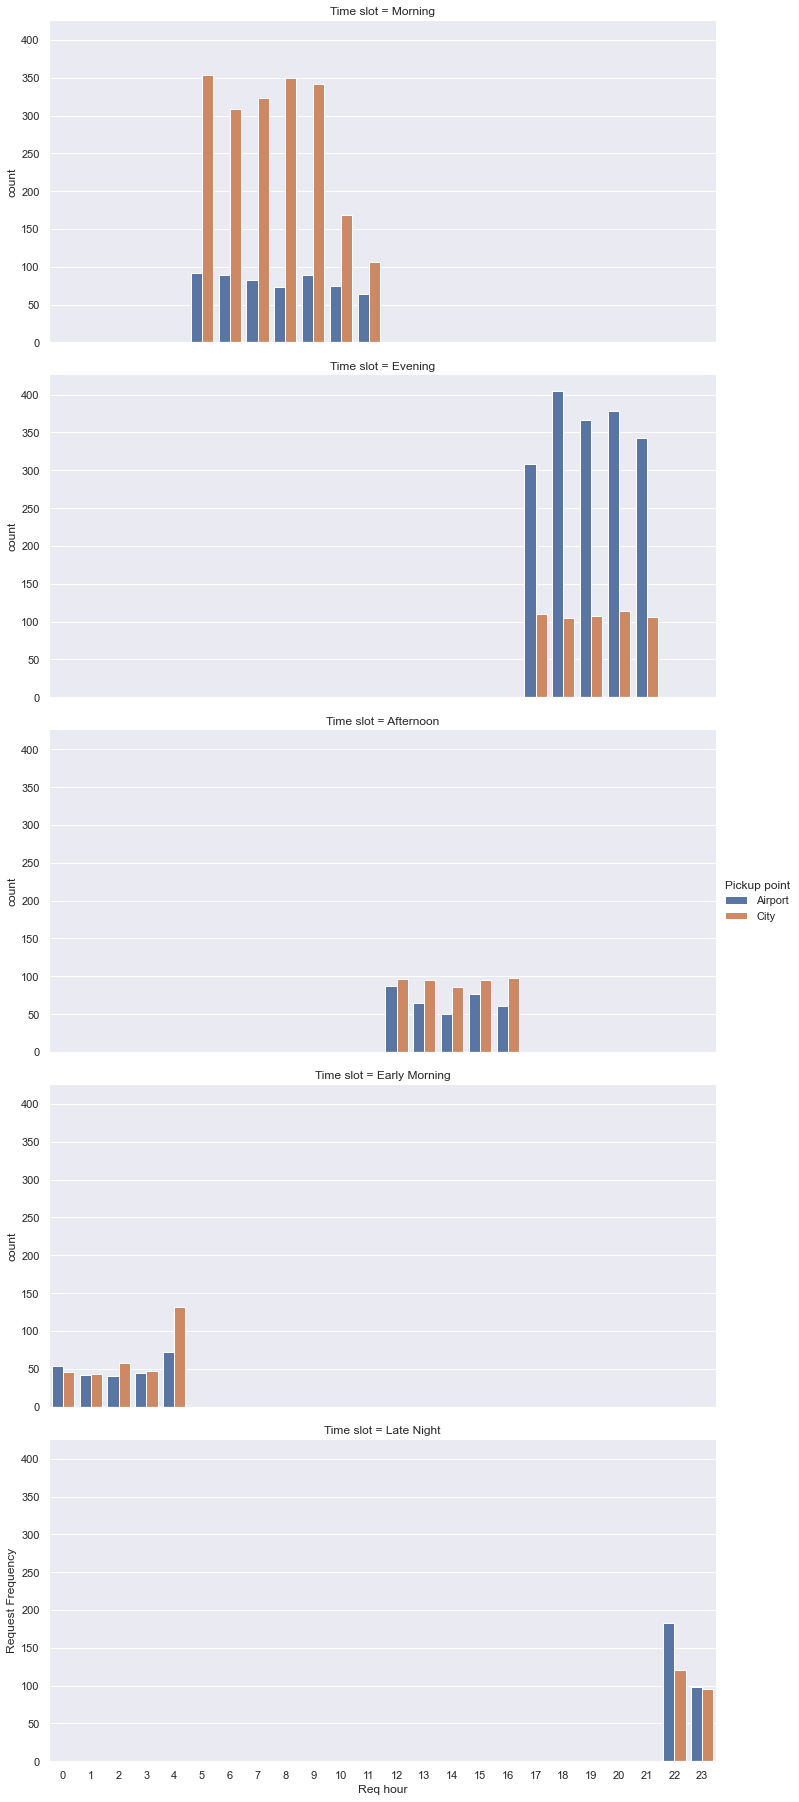

In [30]:
sns.factorplot(x = 'Req hour', hue = 'Pickup point', row = 'Time slot', data = df, kind = 'count', aspect=2)
# Number of requests grouped by Time slot based on pickup points.
plt.ylabel('Request Frequency')
plt.show()

In [24]:
df['Drop hour'] = df["Drop timestamp"].dt.hour

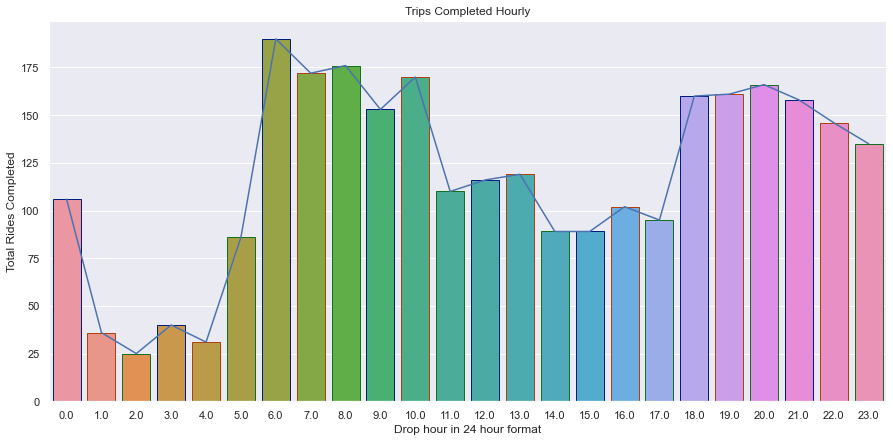

In [25]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(15,7))
plt.title('Trips Completed Hourly')
df.groupby(df['Drop hour']).count()['Request id'].plot(ax=ax)
sns.countplot(df['Drop hour'], edgecolor=sns.color_palette("dark", 3))
plt.xlabel('Drop hour in 24 hour format')
plt.ylabel('Total Rides Completed')
plt.show()


We can see that 6am has the highest drop time. The time period from 1am to 4am is significantly lower compared to others as most people don't take a ride at that time and even less flights land or take off during this period.

## Critcial Analysis during Rush Hours

In [26]:
# I am creating pie charts to provide percentage analysis for easier interpretation of visual data.
def pie_chart(dataframe):
    
    labels = dataframe.index.values
    sizes = dataframe['Status'].values
        
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, 
            labels=labels,
            autopct='%1.1f%%',
            shadow=False,
            startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

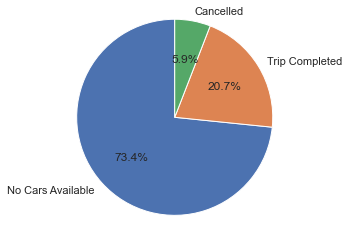

In [27]:
# Status of trips during Evenings rush hour when pickup point is Airport
airpot_to_city_evenings = df.loc[(df["Pickup point"] == "Airport") & (df["Time slot"] == "Evening")]
airpot_to_city_count = pd.DataFrame(airpot_to_city_evenings.Status.value_counts())
pie_chart(airpot_to_city_count)


Almost 80% (79.3% precise) of trips are not completed when requests originate from Airport during Evenings.

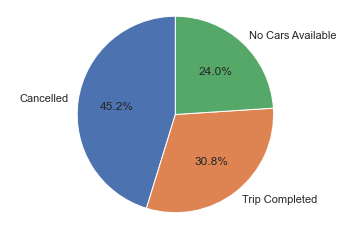

In [28]:
# Status of trips during morning rush hour when pickup point is City
city_to_airport_mornings = df.loc[(df["Pickup point"] == "City") & (df["Time slot"] == "Morning")]
city_to_airport_count = pd.DataFrame(city_to_airport_mornings.Status.value_counts())
pie_chart(city_to_airport_count)

A 70% demand-supply gap exists when requests originate from City and during Mornings.